In [2]:
"""
* autograd: automatic gradient
* This is an implementation of backproagation: Compute the gradient of a loss function in respect to the weight.
"""
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def f(x):
    return 3 * x ** 2 - 4 * x + 5

In [4]:
f(3.0)

20.0

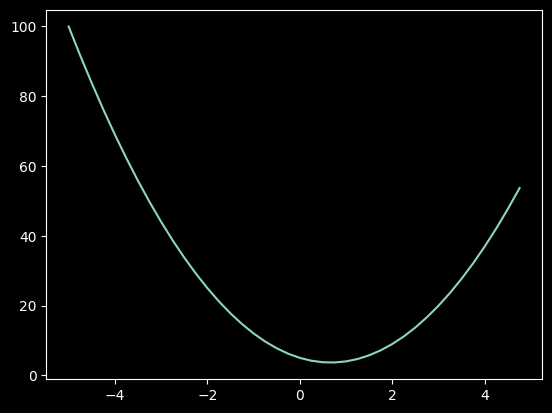

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
h = 0.001
x = 3.0
f(x + h)

20.014003000000002

In [7]:
# From the limit definition (f(x+h) - f(x))/h
h = 0.000001
(f(x + h) - f(x)) / h

14.000003002223593

In [8]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [9]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0
d1 = a * b + c
c += h
d2 = a * b + c
print(f'd1={d1}')
print(f'd2={d2}')
print(f'slope is {(d2 - d1) / h}')
print(d)

d1=4.0
d2=4.0001
slope is 0.9999999999976694
4.0


In [68]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self.label = label
        self._backward = lambda: None
        self.grad = 0
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Value(data={self.data}, children={self._prev}, operator={self._op}, label={self.label})"

    def __add__(self, other):
        out = Value(self.data + other.data, (other, self), '+')

        def _backward():
            """Backward propagation function.

            Here we want to create a closure that can compute the self and other grads based on the out.grad.

            For further examples we have seen that during an addition the gradient is backpropagated without any transformations.
            """
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (other, self), '*')

        def backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = backward

        return out

    def tanh(self):
        """tanh is a hyperbolic function https://en.wikipedia.org/wiki/Hyperbolic_functions."""
        # print(f"Inside tanh")
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')

        def backward():
            self.grad += (1 - t ** 2) * out.grad

        out._backward = backward
        return out

    def backward(self):
        topo: list[Value] = []
        visited: set[Value] = set()

        def build_topological_order(v: Value):
            if v is None:
                return

            if v in visited:
                return

            for child in v._prev:
                build_topological_order(child)

            topo.append(v)
            visited.add(v)

        build_topological_order(self)

        self.grad=1
        for node in reversed(topo):
            node._backward()




In [11]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
a

Value(data=2.0, children=set(), operator=, label=a)

In [12]:
a

Value(data=2.0, children=set(), operator=, label=a)

In [13]:
a + b

Value(data=-1.0, children={Value(data=2.0, children=set(), operator=, label=a), Value(data=-3.0, children=set(), operator=, label=b)}, operator=+, label=)

In [14]:
a * b

Value(data=-6.0, children={Value(data=2.0, children=set(), operator=, label=a), Value(data=-3.0, children=set(), operator=, label=b)}, operator=*, label=)

In [15]:
c = Value(10.0, label='c')
e = a * b
e.label = 'e'
d = e +
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'

In [16]:
from graphviz import Digraph


# DFS
def trace(root):
    nodes, edges = set(), set()

    def build(v, number_of_tabs=0):
        if v not in nodes:
            indentation = number_of_tabs * '\t'
            # print(f"{indentation}Processing node {v}")
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child, number_of_tabs + 1)

    build(root)
    # print(nodes,edges)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    # print(f'Root is {root}')
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # print(f'This is n {n}')
        dot.node(name=uid, label="{ %s | data  %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [17]:
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0

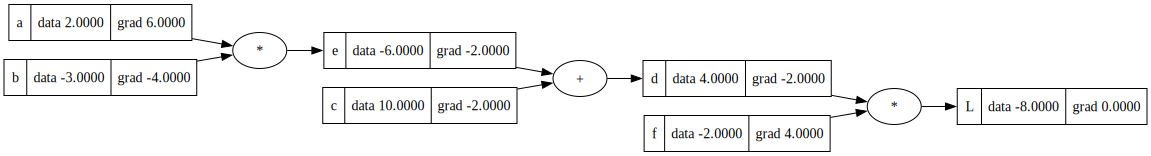

In [18]:
draw_dot(L)

In [19]:
def lol():
    """
    By using this expression we can verify the partial derivatives (grad) that we have computed manually.
    If we add h to a,b,c,d,e,f respectively and check the lim expression for (L2-L1)/h we can verify our 
    assumptions for the grads.
    """
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    # c.data = c.data + h
    e = a * b
    e.label = 'e'
    e.data = e.data + h
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L2 = L.data

    # print(L1)
    # print(L2)
    print((L2 - L1) / h)


In [20]:
lol()

-2.000000000000668


In [21]:
"""
L = d*f

dL/dd = f
(f(x+h) - f(x))/h = ((d+h)f - df)h = (df + fh - df)h = fh/h = f The same stands for the next expression. 

dL/df = d

The most important node is c and here we need to derive dL/dc
We can go about this through its relation with d. L is directly related to d and d is directly related to c. So what is the value of this expression:

dd/dc

d = c + e

(f(x+h) - f(x))/h = ((c+e+h) - (c+e))h = (c+e+h - c-e)/h = h/h=1

by symmetry dd/de = 1.0 as well

WANT:
dL/dc

HAVE:
dL/dd => immediate connection - local
dd/dc => immediate connection - local

CHAIN RULE: https://en.wikipedia.org/wiki/Chain_rule
dL/dc = (dL/dd) * (dd/dc) 

Thus c.grad = d.grad * 1 = -2*1 = -2

And then we can recurse using the chain rule for the first nodes of the expression.

WANT:
dL/da

HAVE:
dL/de

CHAIN RULE => dL/da = (dL/de)*(de/da) => e.grad * b = -2*(-3)

e = a * b

(f(x+h) - f(x))/h = ((a+h)b - ab)/h = (ab + hb - ab)/h = hb/h = b => de/da = b

and

WANT:
dL/db

HAVE:
dL/de

CHAIN RULE => dL/db = (dL/de)*(de/db)  = e.grad * a = (grad of the forward node)*(data of the backward node) -2*(2) = -4

* Forward node is the on sitting closer to the output of the neutal network

(f(x+h) - f(x))/h = (a(b+h) - ab)/h = (ab + ha - ab)/h = ha/h = a => de/db = a
"""

'\nL = d*f\n\ndL/dd = f\n(f(x+h) - f(x))/h = ((d+h)f - df)h = (df + fh - df)h = fh/h = f The same stands for the next expression. \n\ndL/df = d\n\nThe most important node is c and here we need to derive dL/dc\nWe can go about this through its relation with d. L is directly related to d and d is directly related to c. So what is the value of this expression:\n\ndd/dc\n\nd = c + e\n\n(f(x+h) - f(x))/h = ((c+e+h) - (c+e))h = (c+e+h - c-e)/h = h/h=1\n\nby symmetry dd/de = 1.0 as well\n\nWANT:\ndL/dc\n\nHAVE:\ndL/dd => immediate connection - local\ndd/dc => immediate connection - local\n\nCHAIN RULE: https://en.wikipedia.org/wiki/Chain_rule\ndL/dc = (dL/dd) * (dd/dc) \n\nThus c.grad = d.grad * 1 = -2*1 = -2\n\nAnd then we can recurse using the chain rule for the first nodes of the expression.\n\nWANT:\ndL/da\n\nHAVE:\ndL/de\n\nCHAIN RULE => dL/da = (dL/de)*(de/da) => e.grad * b = -2*(-3)\n\ne = a * b\n\n(f(x+h) - f(x))/h = ((a+h)b - ab)/h = (ab + hb - ab)/h = hb/h = b => de/da = b\n\nand\n\

In [22]:
"""
To put this into practice, after we found the gradients, we can perform the following logic check:
* Now we know how the individual nodes on the compute graph above affect the end result L
* Thus in order to increase the number of L, we need to adjust all values to the direction of their gradient
    * a has a positive gradient. This means that whenever a increases a little, L will increase as well. thus we need to increase it
    * b has a negative gradient. This means that whenever b increases a little, this will have an OPPOSITE effect on L. This will decrease L.

We do not really need to care a lot about the positive or negative nature of the gradients. The example bellow explains the adjustments in practice
"""
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad
e = a * b
d = e + c
L = d * f
print(L.data)

-7.286496


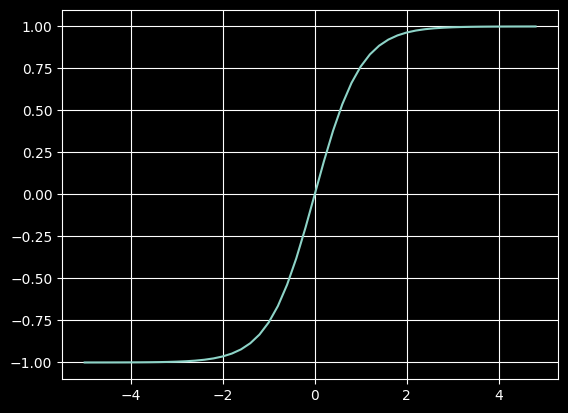

In [23]:
"""
Now we are going to backpropagate through a neuron
"""

# Neuron's/Perceptron's Activation Function
x = np.arange(-5, 5, 0.2)
y = np.tanh(x)
plt.plot(x, y);
plt.grid()

In [62]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')
# b = Value(1.3245, label='b')

# x1*w1 + x2*w2 + b: This is the dot product based on the perceptron definition sigma(x(i)*w(i)) + bibas
x1w1 = x1 * w1
x1w1.label = 'x1*w1'
x2w2 = x2 * w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'  # dot product result
o = n.tanh()
o.label = 'o'

In [38]:
o.grad = 1.0

In [26]:
n.grad = 0.5

In [27]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [28]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [29]:
w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad

w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad

In [46]:
o.grad = 1.0

In [47]:
o._backward()

In [49]:
n._backward()

In [ ]:
# This is going to change nothing since it's an end node
b._backward()

In [53]:
x1w1x2w2._backward()

In [54]:
x1w1._backward()

In [56]:
x2w2._backward()

In [ ]:
"""Topological sort.

We invoked the backwards method in topological order. Since out backwards methods depend on out.grad we need to
1. Set a base case
2. Have the value of the interacting nodes

To create this order we need to be sure about the list of dependencies.

And then we can take this code and put in the Value abstraction
"""
topo: list[Value] = []
visited: set[Value] = set()


def build_topological_order(v: Value):
    if v is None:
        return

    if v in visited:
        return

    for child in v._prev:
        build_topological_order(child)

    topo.append(v)
    visited.add(v)


build_topological_order(o)

for v in reversed(topo):
    v._backward()




In [64]:
o.backward()

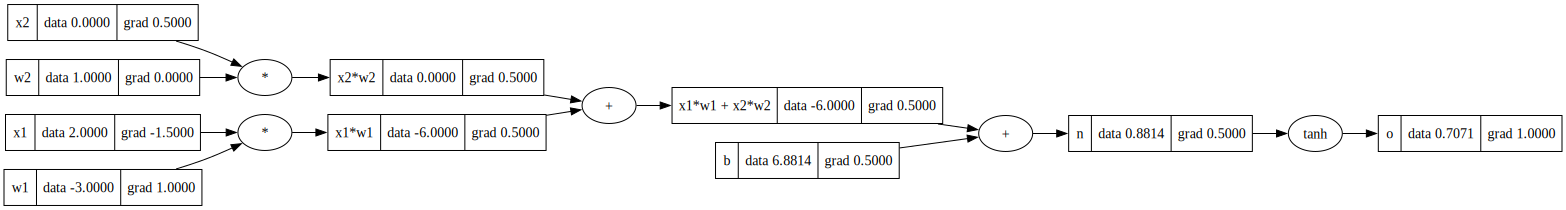

In [65]:
draw_dot(o)

In [31]:
"""
o = tanh(n)
do/dn = ???

From the derivatives section here https://en.wikipedia.org/wiki/Hyperbolic_functions#Derivatives, we choose the second formula for the hyperbolic derivative

do/dn = 1 - tanh(n)**2 => (tanh(n)=o) => do/dn = 1 - o**2
"""
1 - o.data ** 2

0.4999999999999999

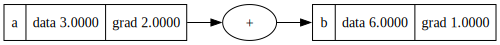

In [69]:
"""Bug

There's an issue with this implementation and this surfaces when we use the same variables for one expression. e.g. b = a + a. With the current code we would get a derivative of 1 for db/da while it should be 2.

For the explanation of the solution check https://en.wikipedia.org/wiki/Chain_rule#Multivariable_case.
"""
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

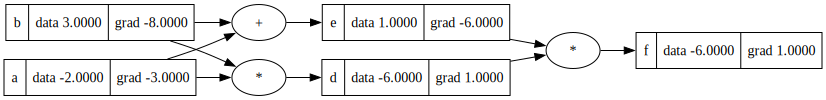

In [70]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [ ]:
"""Breaking down tanh to its constituents.


"""